Targeting junior achievement forms with new forms report. These are identified by the __"HPO - JA"__ tag.

In [5]:
import pandas as pd
import numpy as np
import datetime

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

In [6]:
%matplotlib inline

In [7]:
JA_ORGS = [438371, 444006, 441879, 441891, 444525,
            433162, 93188, 441747, 443576, 443134,
            441649, 442078, 434194, 443081, 443252,
            444359, 444918, 444209, 11189, 445523,
            441556, 441545, 443696, 446218, 445619,
            441603, 443895, 442052, 441669, 441957,
            442314, 444743, 438295, 442339, 443980,
            437266, 444565, 444496, 442615, 205828,
            442652, 441659, 443762, 445420, 444663,
            443761, 436234, 14256, 446331, 443534,
            442618, 446080, 441565, 8153, 441707,
            9139, 442295, 433165, 438405, 441572,
            443199, 443466, 443078, 398340, 441900,
            441700, 198659, 438296, 442028, 441861,
            441646, 442235, 441400, 441774, 438362,
            442407, 441589, 427080, 152579, 442859,
            442832, 419843, 166915, 443034, 442518,
            553, 441721, 442188, 442438, 443416,
            443362, 442610, 442259, 443433, 441958,
            428047, 425990, 445556, 447602, 441539,
            441530, 430212, 441908, 92165, 432157]

# load data

In [8]:
START_DATE = '2020-10-01'

In [9]:
# form status
q = "select id, status, org from form"
all_forms = redshift_query_read(q, schema='production')
all_forms = all_forms[all_forms['org'].isin(JA_ORGS)]
active_forms = all_forms[all_forms['status']==1]['id'].tolist()

In [10]:
JA_FORMS = all_forms['id'].tolist()

In [11]:
print("{:,} forms".format(len(all_forms)))
print("{:,} forms with active status".format(len(active_forms)))

4,700 forms
1,694 forms with active status


### embeds

In [12]:
# embeds
q = "select widget as form from embed"
embeds = redshift_query_read(q, schema='production')
embeds = embeds[embeds['form'].isin(JA_FORMS)]

In [13]:
def is_embed(r):
    if r['form'] in embeds['form'].unique().tolist():
        return True
    return False

### form upgrades

In [14]:
# logged upgrades
q = "select * from syslog_logs where message like '%Qgiv Form Template Upgraded%'"
form_upgrades = redshift_query_read(q, schema="production")[['org', 'form', 'created']]
form_upgrades = form_upgrades[form_upgrades['org'].isin(JA_ORGS)]
forms_upgrades_ids_logged = form_upgrades['form'].unique().tolist()

In [15]:
print("first form upgrade: {}".format(form_upgrades['created'].min()))
print("last form upgrade: {}".format(form_upgrades['created'].max()))

first form upgrade: 2020-12-14 10:26:39
last form upgrade: 2022-01-04 11:30:23


In [16]:
# created new template forms
bucket = "qgiv-stats-data"
new_form_template_list = "form_download.csv"
new_forms = get_dataframe_from_file(bucket, new_form_template_list)

new_forms = new_forms[new_forms['Form ID'].isin(JA_FORMS)]

new_forms['Go Live Date'] = pd.to_datetime(new_forms['Go Live Date'])

new_forms = new_forms[~new_forms['Form ID'].isin(forms_upgrades_ids_logged)]
new_forms = new_forms[(new_forms['Status']=='active')&(new_forms['Go Live Date']>=START_DATE)]
new_forms_ids = new_forms['Form ID'].unique().tolist()

In [17]:
print("{:,} forms upgraded (noted in logs)".format(len(forms_upgrades_ids_logged)))
print("{:,} forms with new template (production export)".format(len(new_forms)))
print("{:,} forms with new template and active status (production export)".format(len(new_forms_ids)))
print()
print("{:,} new template forms & active".format(len([f for f in set(forms_upgrades_ids_logged + new_forms_ids) if f in active_forms])))
print("\n\nlog entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset")

506 forms upgraded (noted in logs)
167 forms with new template (production export)
167 forms with new template and active status (production export)

587 new template forms & active


log entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset


In [18]:
form_upgrades['month'] = form_upgrades['created'].dt.to_period('M')
form_upgrades['active'] = form_upgrades['form'].isin(active_forms)
monthly_upgrades = form_upgrades.groupby(['month', 'active'])['form'].nunique().reset_index()
monthly_upgrades = monthly_upgrades.pivot(index='month', columns='active', values='form').reset_index()
monthly_upgrades.columns = ['month', 'not active', 'active']

print("template conversions")
monthly_upgrades

template conversions


,month,not active,active
0,2020-12,2.0,3.0
1,2021-01,13.0,23.0
2,2021-02,8.0,21.0
3,2021-03,6.0,19.0
4,2021-04,6.0,3.0
5,2021-05,2.0,4.0
6,2021-06,5.0,10.0
7,2021-07,5.0,9.0
8,2021-08,4.0,17.0
9,2021-09,18.0,134.0


In [19]:
new_forms['month'] = new_forms['Go Live Date'].dt.to_period('m')

print("created new template forms")
new_forms.groupby('month')['Form ID'].count().reset_index()

created new template forms


,month,Form ID
0,2020-10,2
1,2020-11,11
2,2020-12,11
3,2021-01,4
4,2021-02,11
5,2021-03,6
6,2021-04,16
7,2021-05,5
8,2021-06,3
9,2021-07,11


In [20]:
def is_new_template(daily_row):
    try:
        # check for log conversion
        if daily_row['form'] in form_upgrades['form'].unique().tolist():
            # is date after logged upgrade date?
            return daily_row['date'] >= form_upgrades[form_upgrades['form']==daily_row['form']]['created'].iloc[0]
        else:
            # form created as new form template
            return daily_row['form'] in new_forms_ids
    except:
        print("error with form {}".format(daily_row['form']))
        raise Exception

### transactions

In [21]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(START_DATE), schema='production')
trans_onetime = trans_onetime[trans_onetime['form'].isin(JA_FORMS)]
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

### transactions

In [15]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

In [22]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

24,540 transactions, 24,540 unique
623 forms


In [23]:
q_trans_rec = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring!=0 and
                        (source='don_form' or source='mobile')'''
trans_rec = redshift_query_read(q_trans_rec.format(START_DATE), schema='production')
trans_rec = trans_rec[trans_rec['form'].isin(JA_FORMS)]
trans_rec['is_recurring'] = True

trans_rec = trans_rec[trans_rec['id']!=12774333]

In [24]:
print("{:,} recurring transactions, {:,} unique".format(len(trans_rec), len(trans_rec['id'].unique())))
print("{:,} forms".format(len(trans_rec['form'].unique())))

4,450 recurring transactions, 4,450 unique
134 forms


In [25]:
trans = trans_onetime.append(trans_rec)

In [26]:
print("forms: {:,}".format(trans['form'].nunique()))
print("transactions: {:,}, {:,} unique".format(len(trans), trans['id'].nunique()))
print("one time transactions: {:,}, {:,} unique".format(len(trans[~trans['is_recurring']]), trans[~trans['is_recurring']]['id'].nunique()))
print("recurring transactions: {:,}, {:,} unique".format(len(trans[trans['is_recurring']]), trans[trans['is_recurring']]['id'].nunique()))

forms: 645
transactions: 28,990, 28,990 unique
one time transactions: 24,540, 24,540 unique
recurring transactions: 4,450, 4,450 unique


### traffic

In [27]:
trans['date'].min(), trans['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-01-08 00:00:00'))

### traffic

In [29]:
q_ga = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from googleanalytics_traffic
            where
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' '''
traffic = redshift_query_read(q_ga.format(START_DATE), schema='production')
traffic = traffic[traffic['form'].isin(JA_FORMS)]

In [30]:
traffic = traffic.drop_duplicates()

In [31]:
print("{:,} entries; {:,} unique".format(len(traffic), len(traffic.drop_duplicates())))
print("{:,.2f} entries per form".format(traffic.groupby('form')['views'].count().mean()))
print("{:,.2f} observation dates per form".format(traffic.groupby('form')['date'].nunique().mean()))
print("{:,.2f} views per form".format(traffic.groupby('form')['views'].sum().mean()))
print("{:,.2f} views per form per day".format(traffic.groupby(['form', 'date'])['views'].sum().mean()))

193,053 entries; 193,053 unique
101.82 entries per form
38.85 observation dates per form
803.01 views per form
20.67 views per form per day


### merge & compile data

In [32]:
traffic['date'].min(), traffic['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-01-08 00:00:00'))

### merge & compile data

In [26]:
# limit to active forms
#trans = trans[trans['form'].isin(active_forms)]
#traffic = traffic[traffic['form'].isin(active_forms)]

In [34]:
trans['is new template'] = trans[['form', 'date']].apply(is_new_template, axis=1)

In [35]:
trans['is embed'] = trans['form'].isin(embeds['form'].tolist())

In [36]:
trans_all = trans.copy()

trans_onetime = trans[~trans['is_recurring']]
trans_rec = trans[trans['is_recurring']]
trans_rec = trans_rec.groupby('recurring').first().reset_index()

trans = trans_onetime.append(trans_rec)

In [37]:
print("All transactions: {:,} ({:,} unique)".format(len(trans_all), len(trans_all['id'].unique())))
print("One time and originating recurring: {:,}".format(len(trans)))
print()
print("Trans per form: {:,.2f}".format(trans.groupby('form')['amount'].count().mean()))
print("Trans per form per day: {:,.2f}".format(trans.groupby(['form', 'date'])['amount'].count().mean()))
print("One time trans per form: {:,.2f}".format(trans[~trans['is_recurring']].groupby('form')['amount'].count().mean()))
print("Recurring trans per form: {:,.2f}".format(trans[trans['is_recurring']].groupby('form')['amount'].count().mean()))

All transactions: 28,990 (28,990 unique)
One time and originating recurring: 25,177

Trans per form: 39.03
Trans per form per day: 2.22
One time trans per form: 39.39
Recurring trans per form: 4.75


#### daily (all devices) data

In [38]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [39]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 11,466
daily traffic agg len: 73,656
merged dailies len: 73,269


In [43]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [44]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 11,466
daily traffic agg len: 73,656
merged dailies len: 73,269


In [45]:
print("{:,} forms in transaction aggregates".format(len(daily_trans['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies['form'].unique())))
print()

print("2021-07-22:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-07-22']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-07-22')&(trans['recurring']==0)])))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-07-22')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-07-22']['trans_count_onetime'].sum()))
print()

print("2021-05-29:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-05-29']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-05-29')&(trans['recurring']==0)]['id'].unique())))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-05-29')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-05-29']['trans_count_onetime'].sum()))
print()

print("Dailies w/ > 0 transactions and 0 pageviews:")
print("-"*40)
print("{:,} total dailies entries".format(len(dailies)))
print("{:,} entries".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)])))
print("{:,} forms".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)]['form'].unique())))

645 forms in transaction aggregates
1,896 forms in traffic aggregates
1,896 forms in merged dailies

2021-07-22:
----------------------------------------
22 forms in transaction aggregates
224 forms in traffic aggregates
222 forms in merged dailies

28 one time transactions from transactions data
28.0 one time transactions from transactions aggregated data
21.0 forms in merged dailies

2021-05-29:
----------------------------------------
14 forms in transaction aggregates
126 forms in traffic aggregates
124 forms in merged dailies

23 one time transactions from transactions data
23.0 one time transactions from transactions aggregated data
8.0 forms in merged dailies

Dailies w/ > 0 transactions and 0 pageviews:
----------------------------------------
73,269 total dailies entries
0 entries
0 forms


In [46]:
dailies['conversion'] = (dailies['trans_count_onetime'] + dailies['trans_count_recurring']) / dailies['views']
dailies['conversion_onetime'] = dailies['trans_count_onetime'] / dailies['views']
dailies['conversion_recurring'] = dailies['trans_count_recurring'] / dailies['views']

In [47]:
# removing outliers
dailies = dailies[dailies['conversion']<1.]

In [48]:
dailies = dailies[dailies['date']>=START_DATE]

In [49]:
# limiting to prior report range
dailies = dailies[dailies['date']<='2022-01-01']

In [50]:
# need to tag embed & new template by prior entries for 0 transaction days
dailies['is new template'] = dailies[['form', 'date']].apply(is_new_template, axis=1)

In [51]:
dailies['is embed'] = dailies['form'].isin(embeds['form'].tolist())

In [52]:
count_new_template_onetime = dailies[dailies['is new template']]['trans_count_onetime'].sum()
count_new_template_rec = dailies[dailies['is new template']]['trans_count_recurring'].sum()
count_old_template_onetime = dailies[~dailies['is new template']]['trans_count_onetime'].sum()
count_old_template_rec = dailies[~dailies['is new template']]['trans_count_recurring'].sum()
count_new_template = count_new_template_onetime + count_new_template_rec
count_old_template = count_old_template_onetime + count_old_template_rec

perc_new_template_onetime = (count_new_template_onetime / (count_new_template_onetime + count_old_template_onetime)) * 100.
perc_new_template_rec = (count_new_template_rec / (count_new_template_rec + count_old_template_rec)) * 100.
perc_new_template = (count_new_template / (count_new_template + count_old_template)) * 100.

print("{:,} daily aggregate observations old template".format(len(dailies[~dailies['is new template']])))
print("{:,} daily aggregate observations new template".format(len(dailies[dailies['is new template']])))
print()
print("{:,} ({:.2f}%) transactions new template".format(count_new_template, perc_new_template))
print("{:,} ({:.2f}%) onetime transactions new template".format(count_new_template_onetime, perc_new_template_onetime))
print("{:,} ({:.2f}%) recurring transactions new template".format(count_new_template_rec, perc_new_template_rec))

60,930 daily aggregate observations old template
10,132 daily aggregate observations new template

3,685.0 (31.10%) transactions new template
3,637.0 (31.16%) onetime transactions new template
48.0 (27.59%) recurring transactions new template


In [53]:
dailies['date'].min(), dailies['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-01-01 00:00:00'))

# exploration

In [54]:
len_old_temp_zero_conv = len(dailies[(~dailies['is new template'])&(dailies['conversion']==0.0)])
perc_old_temp_zero_conv = (len_old_temp_zero_conv / len(dailies[~dailies['is new template']])) * 100.

len_new_temp_zero_conv = len(dailies[(dailies['is new template'])&(dailies['conversion']==0.0)])
perc_new_temp_zero_conv = (len_new_temp_zero_conv / len(dailies[dailies['is new template']])) * 100.

print("{:,} ({:.2f}%) old template observations w/ 0% conversion".format(len_old_temp_zero_conv, perc_old_temp_zero_conv))
print("{:,} ({:.2f}%) new template observations w/ 0% conversion".format(len_new_temp_zero_conv, perc_new_temp_zero_conv))

57,745 (94.77%) old template observations w/ 0% conversion
8,794 (86.79%) new template observations w/ 0% conversion


In [55]:
template_date_counts = dailies.groupby(['date', 'is new template'])['conversion'].count().reset_index()
template_date_counts = template_date_counts.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_counts.columns = ['date', 'old template', 'new template']

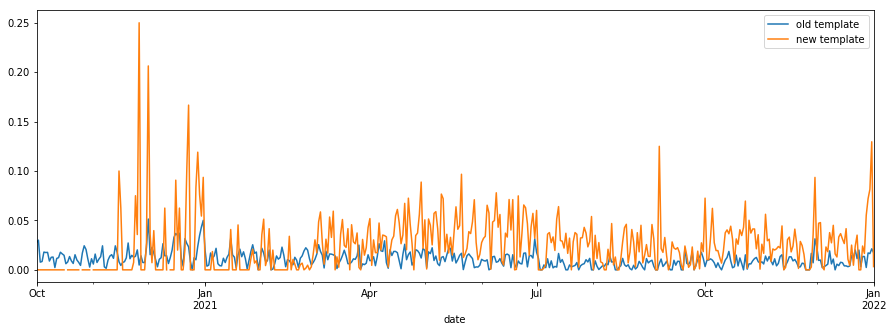

In [56]:
template_date_conv = dailies.groupby(['date', 'is new template'])['conversion'].mean().reset_index()
template_date_conv = template_date_conv.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_conv.columns = ['date', 'old template', 'new template']
template_date_conv.plot(x='date', figsize=(15,5))

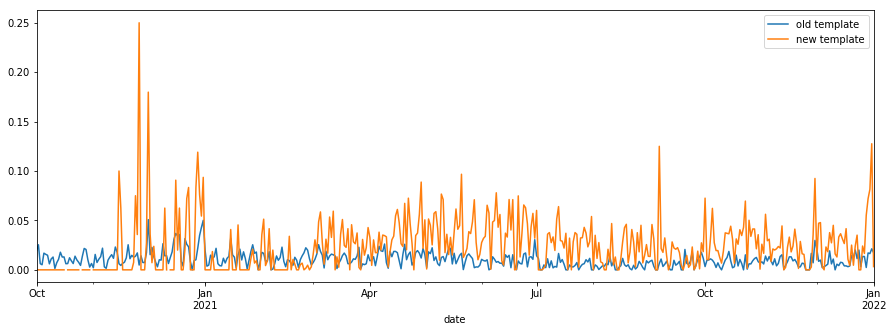

In [57]:
temp_ot_date_conv = dailies.groupby(['date', 'is new template'])['conversion_onetime'].mean().reset_index()
temp_ot_date_conv = temp_ot_date_conv.pivot(index='date', columns='is new template', values='conversion_onetime').reset_index()
temp_ot_date_conv.columns = ['date', 'old template', 'new template']
temp_ot_date_conv.plot(x='date', figsize=(15,5))

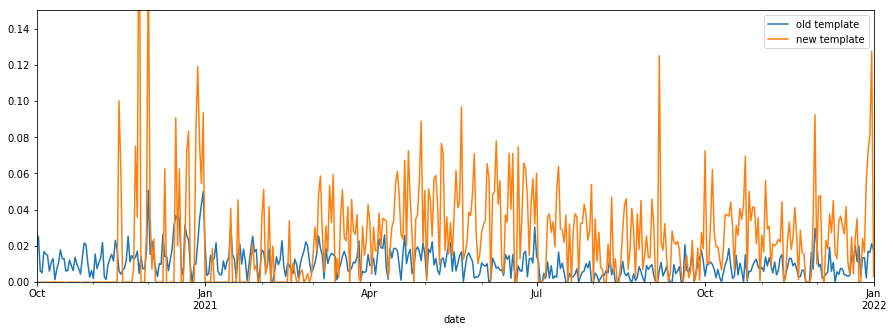

In [58]:
temp_ot_date_conv.plot(x='date', figsize=(15,5), ylim=(0,0.15))

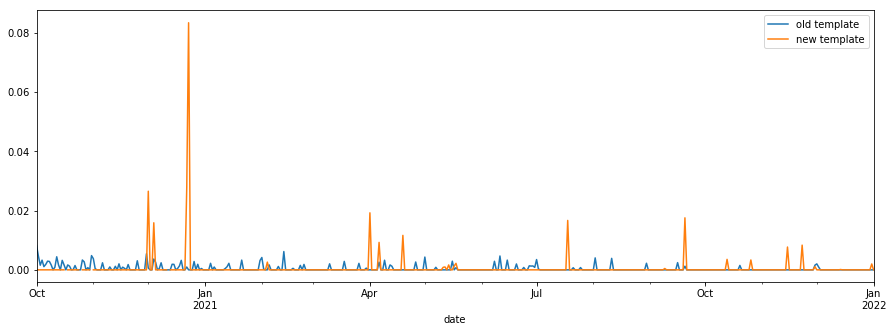

In [59]:
temp_rec_date_conv = dailies.groupby(['date', 'is new template'])['conversion_recurring'].mean().reset_index()
temp_rec_date_conv = temp_rec_date_conv.pivot(index='date', columns='is new template', values='conversion_recurring').reset_index()
temp_rec_date_conv.columns = ['date', 'old template', 'new template']
temp_rec_date_conv.plot(x='date', figsize=(15,5))

In [60]:
dailies[dailies['is new template']].sort_values('conversion_recurring', ascending=False).head()

,date,form,views,bounces,is new template,is embed,trans_count_onetime,trans_count_recurring,trans_vol_onetime,trans_vol_recurring,conversion,conversion_onetime,conversion_recurring
66092,2021-11-15,943194,2.0,1.0,True,True,0.0,1.0,0.0,10.50,0.5,0.0,0.5
67389,2021-11-23,936768,2.0,0.0,True,True,0.0,1.0,0.0,156.00,0.5,0.0,0.5
32398,2021-04-19,969584,2.0,0.0,True,True,0.0,1.0,0.0,25.75,0.5,0.0,0.5
29069,2021-04-01,935166,2.0,0.0,True,True,0.0,1.0,0.0,5000.00,0.5,0.0,0.5
48131,2021-07-18,525,2.0,0.0,True,False,0.0,1.0,0.0,1000.00,0.5,0.0,0.5


In [61]:
len(dailies), len(dailies[dailies['conversion']>1.]), "{:.2f}%".format((len(dailies[dailies['conversion']>1.]) / len(dailies)) * 100.)

(71062, 0, '0.00%')

In [62]:
over_conv_forms = dailies[dailies['conversion']>1.]['form'].unique().tolist()
intersect_over_conv = [f for f in over_conv_forms if f in dailies[dailies['conversion']<1.]['form'].unique()]

print("{:,} forms w/ > 100% conversion".format(len(over_conv_forms)))
print("{:,} forms overlap w/ < 100% conversion".format(len(intersect_over_conv)))

0 forms w/ > 100% conversion
0 forms overlap w/ < 100% conversion


In [63]:
print(len(dailies[dailies['conversion_onetime']>1.]), len(dailies[dailies['conversion_recurring']>1.]))
print("one time: {:.2f}%".format((len(dailies[dailies['conversion_onetime']>1.]) / len(dailies)) * 100.))
print("recurring: {:.2f}%".format((len(dailies[dailies['conversion_recurring']>1.]) / len(dailies)) * 100.))

0 0
one time: 0.00%
recurring: 0.00%


In [64]:
print("total: {:,}".format(len(dailies[dailies['conversion']>1.])))
print("new template: {:,}".format(len(dailies[(dailies['is new template'])&(dailies['conversion']>1.)])))
print("old template: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is new template'])])))
print("embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(dailies['is embed'])])))
print("not embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is embed'])])))

print()
print("old template & embed: {:,}".format(len(dailies[(~dailies['is new template'])&(dailies['is embed'])&(dailies['conversion']>1.)])))

total: 0
new template: 0
old template: 0
embed: 0
not embed: 0

old template & embed: 0


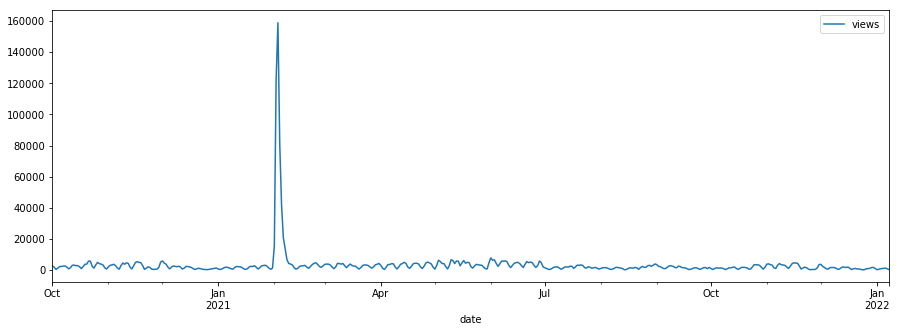

In [65]:
traff_date = traffic.groupby('date')['views'].sum().reset_index()
traff_date.plot(x='date', figsize=(15,5))

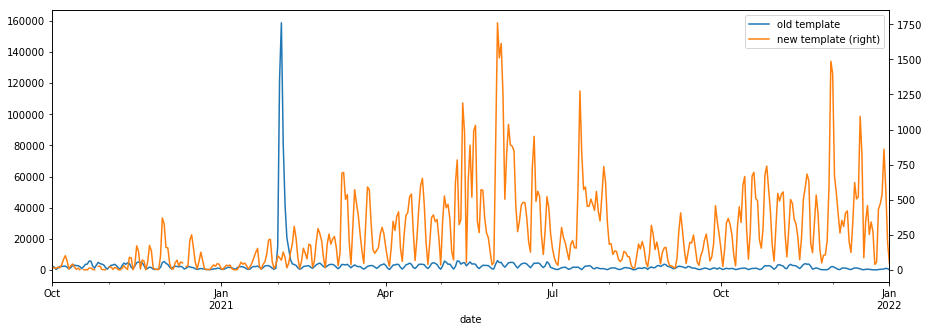

In [66]:
template_date_traf = dailies.groupby(['date', 'is new template'])['views'].sum().reset_index()
template_date_traf = template_date_traf.pivot(index='date', columns='is new template', values='views').reset_index()
template_date_traf.columns = ['date', 'old template', 'new template']
template_date_traf.plot(x='date', secondary_y='new template', figsize=(15,5))

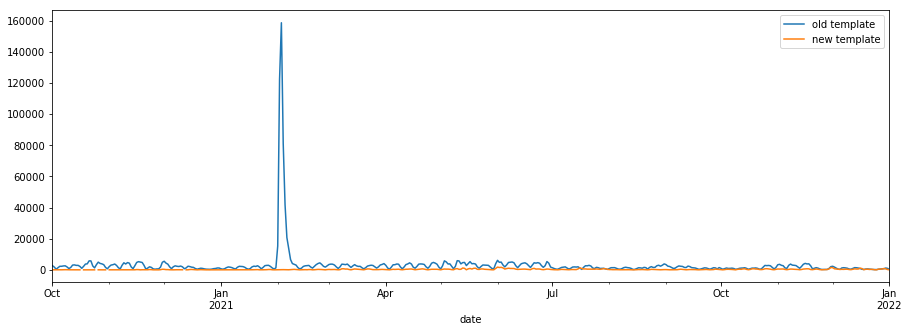

In [67]:
template_date_traf.plot(x='date', figsize=(15,5))

In [68]:
dailies['trans_count'] = dailies['trans_count_onetime'] + dailies['trans_count_recurring']

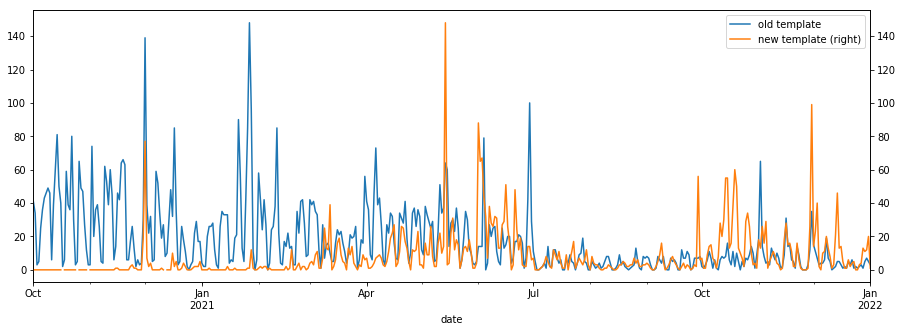

In [69]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_count'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_count').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [70]:
dailies['trans_vol'] = dailies['trans_vol_onetime'] + dailies['trans_vol_recurring']

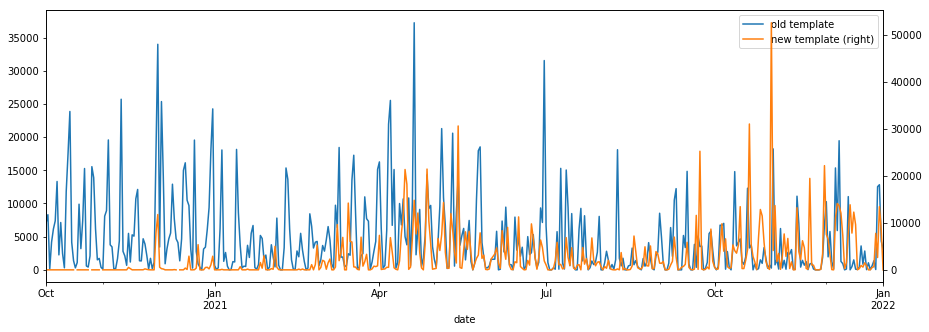

In [71]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_vol'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_vol').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [72]:
template_date_trans.iloc[-28:-23]

,date,old template,new template
430,2021-12-05,141.75,0.00
431,2021-12-06,15355.00,11015.95
432,2021-12-07,5920.00,14101.72
433,2021-12-08,19455.35,13640.50
434,2021-12-09,1272.00,12060.25


_Re: new template spike on 10-04, secure reports for donation form processing shows a similar spike so it appears legit_

#### monthly median transactions

In [73]:
trans['month'] = trans['date'].dt.to_period('M')
trans_monthly_median = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].agg({'median', 'count'}).reset_index()

In [74]:
monthly_medians = trans_monthly_median.pivot(index='month', columns='is new template', values=['count', 'median']).reset_index()
monthly_medians.columns = ['month', 'old template count', 'new template count', 'old template median', 'new template median']

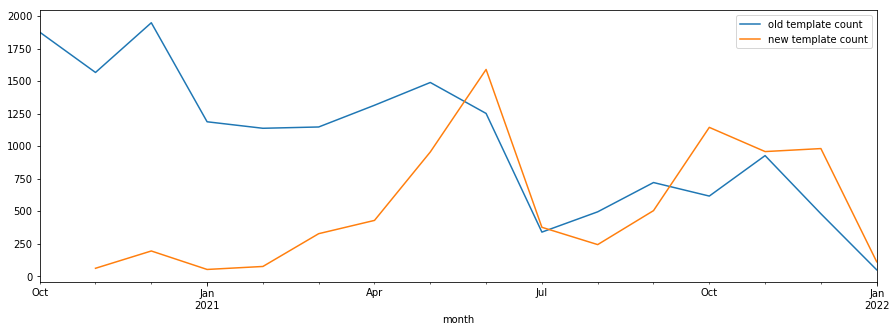

In [75]:
monthly_medians.plot(x='month', y=['old template count', 'new template count'], figsize=(15,5))

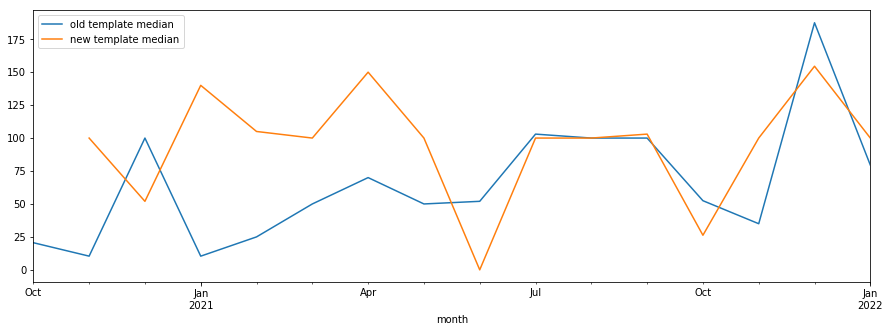

In [76]:
monthly_medians.plot(x='month', y=['old template median', 'new template median'], figsize=(15,5))

In [77]:
trans_monthly_sums = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [78]:
monthly_sums = trans_monthly_sums.pivot(index='month', columns='is new template', values=['amount']).reset_index()
monthly_sums.columns = ['month', 'old template vol', 'new template vol']

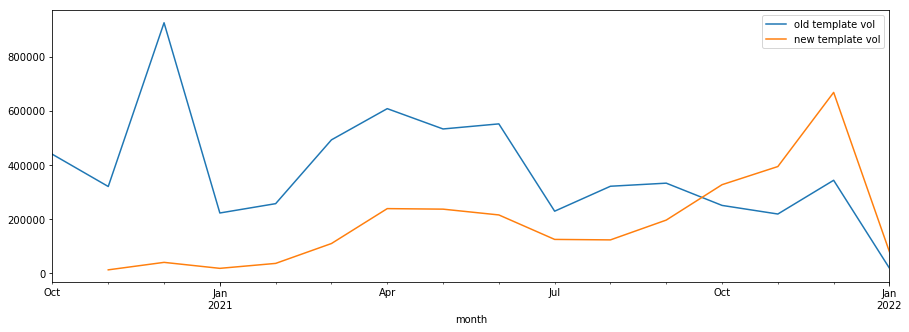

In [79]:
monthly_sums.plot(x='month', figsize=(15,5))

In [80]:
trans_monthly_counts = trans.groupby(['month', 'is new template', 'is_recurring'])['id'].nunique().reset_index()
trans_monthly_counts = trans_monthly_counts.pivot(index='month', columns=['is new template', 'is_recurring'], values='id').reset_index()
trans_monthly_counts.columns = ['month', 'one time old template', 
                                'recurring old template', 'one time new template',
                                'recurring new template']

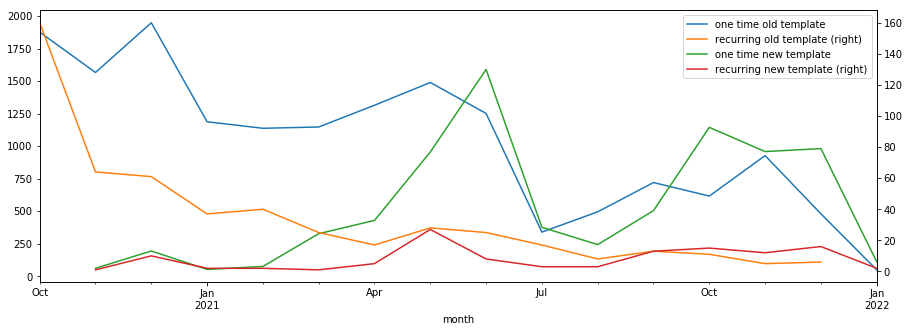

In [81]:
secondary_ys = ['recurring old template', 'recurring new template']
trans_monthly_counts.plot(x='month', secondary_y=secondary_ys, figsize=(15,5))

#### monthly onetime/recurring ratio

In [82]:
trans['month'] = trans['date'].dt.to_period('m')
monthly_ratios = trans.groupby(['month', 'is_recurring', 'is new template'])['id'].nunique().reset_index()

In [83]:
monthly_ratios = monthly_ratios.pivot(index='month', columns=['is_recurring', 'is new template'], values='id').reset_index()
monthly_ratios.columns = ['month', 'onetime old template', 'onetime new template', 'recurring old template', 'recurring new template']
monthly_ratios['new template ratio'] = monthly_ratios['onetime new template'] / monthly_ratios['recurring new template']
monthly_ratios['old template ratio'] = monthly_ratios['onetime old template'] / monthly_ratios['recurring old template']

In [84]:
monthly_ratios.tail(12)

,month,onetime old template,onetime new template,recurring old template,recurring new template,new template ratio,old template ratio
4,2021-02,1137.0,40.0,75.0,2.0,20.000000,15.160000
5,2021-03,1147.0,25.0,327.0,1.0,25.000000,3.507645
6,2021-04,1314.0,17.0,429.0,5.0,3.400000,3.062937
7,2021-05,1489.0,28.0,955.0,27.0,1.037037,1.559162
8,2021-06,1251.0,25.0,1589.0,8.0,3.125000,0.787288
9,2021-07,339.0,17.0,376.0,3.0,5.666667,0.901596
10,2021-08,495.0,8.0,243.0,3.0,2.666667,2.037037
11,2021-09,720.0,13.0,504.0,13.0,1.000000,1.428571
12,2021-10,616.0,11.0,1144.0,15.0,0.733333,0.538462
13,2021-11,927.0,5.0,958.0,12.0,0.416667,0.967641


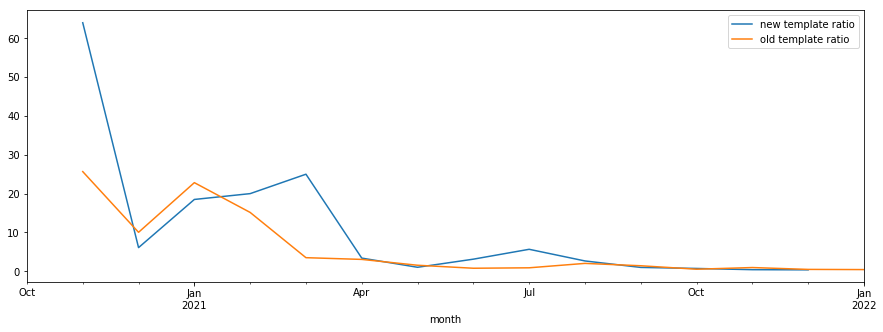

In [85]:
monthly_ratios[['month', 'new template ratio', 'old template ratio']].plot(x='month', figsize=(15,5))

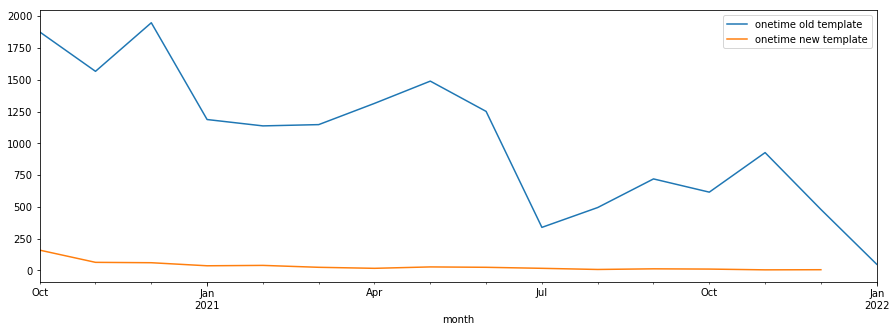

In [86]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', figsize=(15,5))

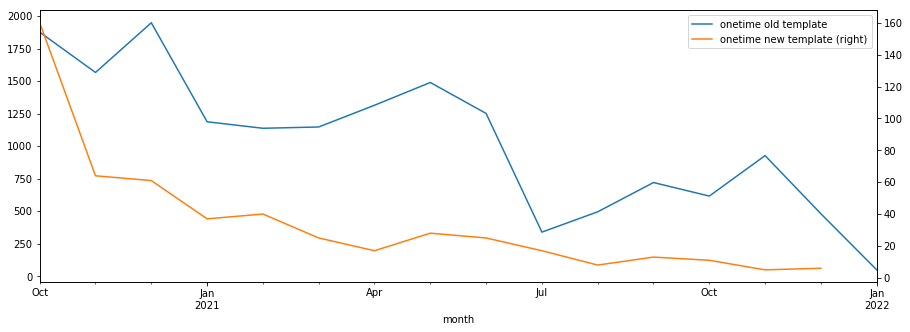

In [87]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', secondary_y='onetime new template', figsize=(15,5))

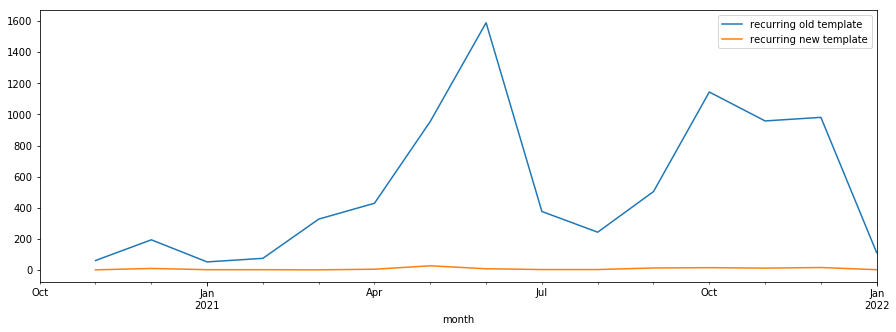

In [88]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', figsize=(15,5))

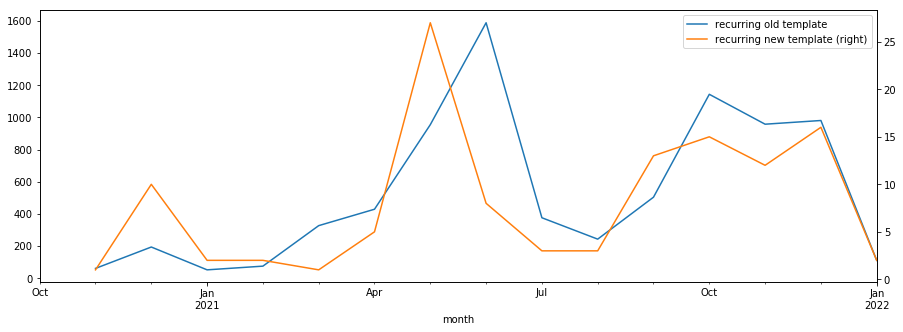

In [89]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', secondary_y='recurring new template', figsize=(15,5))

- one time / recurring over time, one time, recurring, recurring all vs originating
- over time, table

In [90]:
daily_onetime = trans[~trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
daily_onetime.columns = ['date', 'old template onetime', 'new template onetime']

daily_rec_originating = trans[trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_originating = daily_rec_originating.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_originating.columns = ['date', 'old template rec origin', 'new template rec origin']

daily_rec_all = trans_all[trans_all['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_all = daily_rec_all.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_all.columns = ['date', 'old template rec all', 'new template rec all']

daily_trans = daily_onetime.merge(daily_rec_originating, on='date', how='outer').merge(daily_rec_all, on='date', how='outer')

In [91]:
daily_trans.tail(3)

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all
462,2022-01-06,13.0,22.0,NaN,NaN,5.0,7.0
463,2022-01-07,12.0,18.0,NaN,NaN,3.0,2.0
464,2022-01-08,4.0,1.0,NaN,NaN,4.0,NaN


In [92]:
daily_trans['new template onetime / rec origin'] = daily_trans['new template onetime'] / daily_trans['new template rec origin']
daily_trans['new template onetime / rec all'] = daily_trans['new template onetime'] / daily_trans['new template rec all']

daily_trans['old template onetime / rec origin'] = daily_trans['old template onetime'] / daily_trans['old template rec origin']
daily_trans['old template onetime / rec all'] = daily_trans['old template onetime'] / daily_trans['old template rec all']

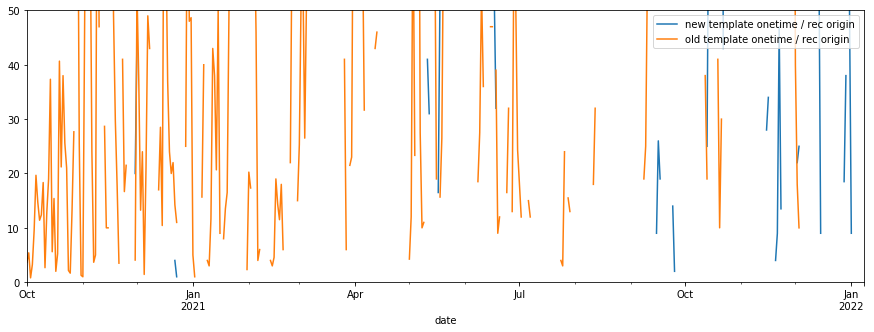

In [93]:
cols = ['date', 'new template onetime / rec origin', 
        'old template onetime / rec origin']
daily_trans[cols].plot(x='date', ylim=(0,50), figsize=(15,5))

In [94]:
cols = ['old template onetime', 'new template onetime',
       'old template rec origin', 'new template rec origin',
       'old template rec all', 'new template rec all']
monthly_trans = daily_trans.groupby(daily_trans['date'].dt.to_period('m'))[cols].sum().reset_index()

In [95]:
monthly_trans['new template onetime / rec origin'] = monthly_trans['new template onetime'] / monthly_trans['new template rec origin']
monthly_trans['new template onetime / rec all'] = monthly_trans['new template onetime'] / monthly_trans['new template rec all']

monthly_trans['old template onetime / rec origin'] = monthly_trans['old template onetime'] / monthly_trans['old template rec origin']
monthly_trans['old template onetime / rec all'] = monthly_trans['old template onetime'] / monthly_trans['old template rec all']

In [96]:
monthly_trans

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all,new template onetime / rec origin,new template onetime / rec all,old template onetime / rec origin,old template onetime / rec all
0,2020-10,1876.0,0.0,160.0,0.0,247.0,0.0,NaN,NaN,11.725000,7.595142
1,2020-11,1566.0,61.0,64.0,1.0,247.0,2.0,61.000000,30.500000,24.468750,6.340081
2,2020-12,1948.0,194.0,61.0,10.0,274.0,22.0,19.400000,8.818182,31.934426,7.109489
3,2021-01,1187.0,52.0,37.0,2.0,256.0,16.0,26.000000,3.250000,32.081081,4.636719
4,2021-02,1137.0,75.0,40.0,2.0,251.0,23.0,37.500000,3.260870,28.425000,4.529880
5,2021-03,1147.0,327.0,25.0,1.0,259.0,26.0,327.000000,12.576923,45.880000,4.428571
6,2021-04,1314.0,429.0,17.0,5.0,248.0,38.0,85.800000,11.289474,77.294118,5.298387
7,2021-05,1489.0,955.0,28.0,27.0,265.0,60.0,35.370370,15.916667,53.178571,5.618868
8,2021-06,1251.0,1589.0,25.0,8.0,272.0,47.0,198.625000,33.808511,50.040000,4.599265
9,2021-07,339.0,376.0,17.0,3.0,248.0,38.0,125.333333,9.894737,19.941176,1.366935


#### monthly volumes

In [97]:
these_trans = trans[(trans['is new template'])&(trans['month']=='2021-07')]

print("07/2021 new template transactions: {:,}".format(len(these_trans)))
print("\tunique transactions: {:,}".format(these_trans['id'].nunique()))
print()

these_trans.sort_values('amount').tail()

07/2021 new template transactions: 379
	unique transactions: 379



,id,date,form,amount,recurring,source,useragent,is_recurring,is new template,is embed,month
773545,12826777,2021-07-28,947480,5000.0,0,don_form,Mozilla50WindowsNT100WOW64AppleWebKit53736KHTM...,False,True,False,2021-07
859215,12817551,2021-07-26,970289,5000.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,False,2021-07
861952,12750273,2021-07-15,970289,5000.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,False,2021-07
786173,12698613,2021-07-07,969722,5000.0,0,don_form,Mozilla50MacintoshIntelMacOSX10157AppleWebKit6...,False,True,False,2021-07
743590,12729831,2021-07-12,947480,5250.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,False,2021-07


In [98]:
monthly_volume = trans.groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [99]:
monthly_vol = monthly_volume.pivot(index='month', columns='is new template', values='amount').reset_index()
monthly_vol.columns = ['month', 'old template volume', 'new template volume']
monthly_vol.tail()

,month,old template volume,new template volume
11,2021-09,335377.75,199462.57
12,2021-10,252456.82,330174.18
13,2021-11,220528.12,397145.35
14,2021-12,345063.37,670679.40
15,2022-01,19526.08,80301.77


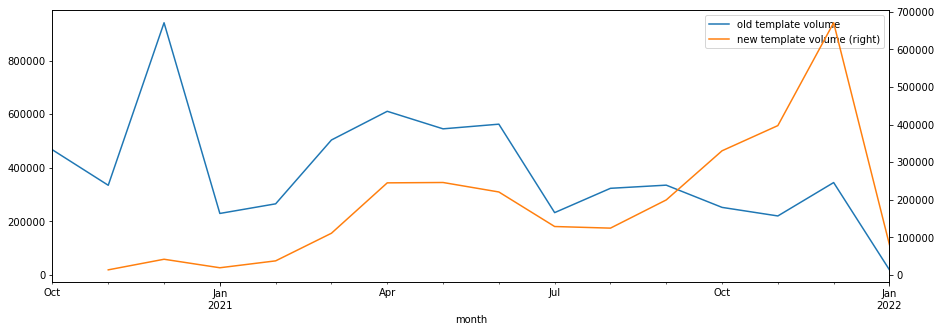

In [100]:
monthly_vol.plot(x='month', secondary_y='new template volume', figsize=(15,5))

#### form sample sizes

In [101]:
print("Dailies:")
print("\tnew template: {:,}".format(len(dailies[dailies['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(dailies[~dailies['is new template']]['form'].unique())))
print()

print("Transactions:")
print("\tnew template: {:,}".format(len(trans[trans['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(trans[~trans['is new template']]['form'].unique())))

Dailies:
	new template: 416
	old template: 1,679

Transactions:
	new template: 299
	old template: 472


In [102]:
daily_forms = dailies.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_forms = daily_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_forms.columns = ['date', 'old template', 'new template']

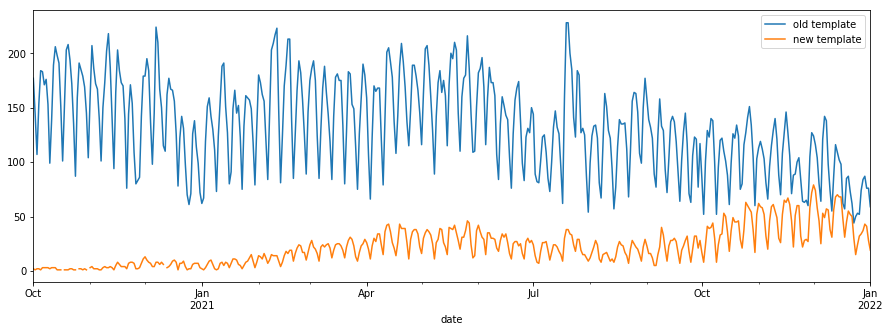

In [103]:
daily_forms.plot(x='date', figsize=(15,5))

In [104]:
daily_trans_forms = trans.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_trans_forms = daily_trans_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_trans_forms.columns = ['date', 'old template', 'new template']

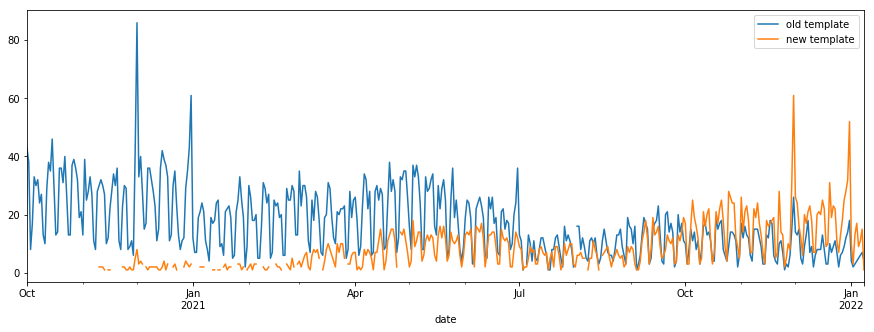

In [105]:
daily_trans_forms.plot(x='date', figsize=(15,5))

#### trans vs dailies one time

In [106]:
daily_onetime = dailies.groupby(['date', 'is new template'])['trans_count_onetime'].sum().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='trans_count_onetime').reset_index()
daily_onetime.columns = ['date', 'old template', 'new template']

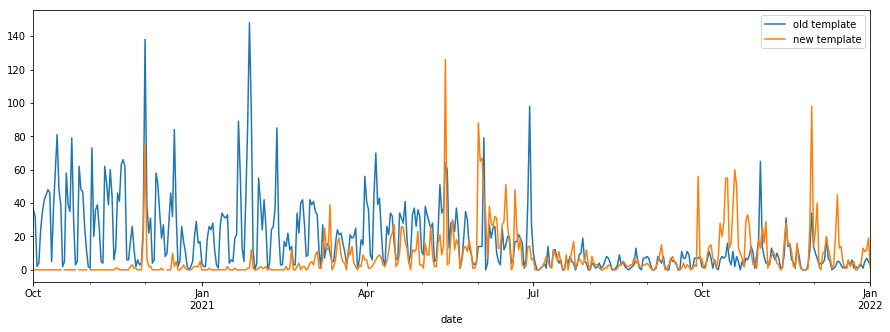

In [107]:
daily_onetime.plot(x='date', figsize=(15,5))

In [108]:
trans_onetime = trans[trans['recurring']==0].groupby(['date', 'is new template'])['id'].nunique().reset_index()
trans_onetime = trans_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
trans_onetime.columns = ['date', 'old template', 'new template']

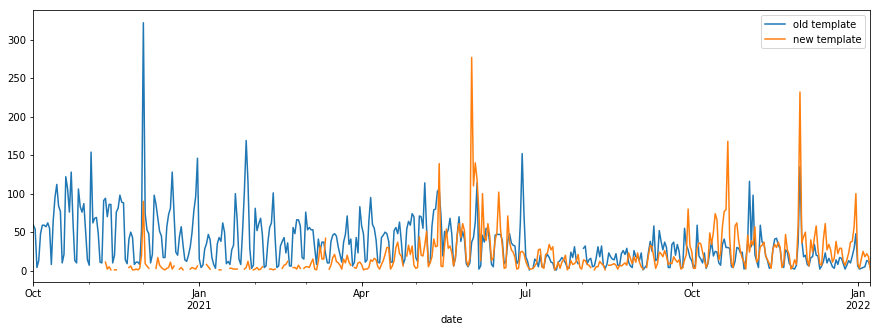

In [109]:
trans_onetime.plot(x='date', figsize=(15,5))

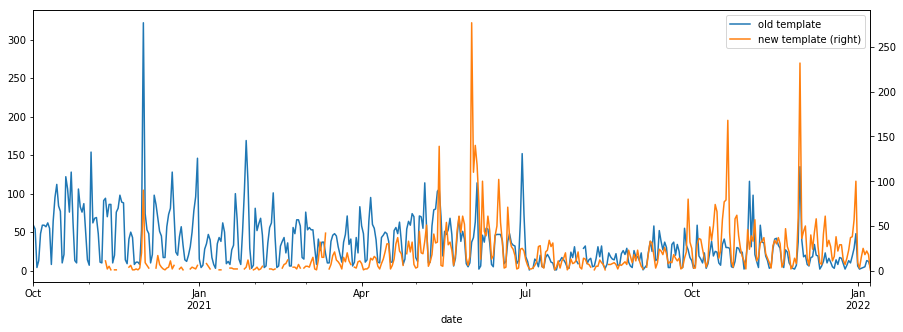

In [110]:
trans_onetime.plot(x='date', secondary_y='new template', figsize=(15,5))

In [111]:
iso_trans = trans[(trans['date']=='2021-02-25')&(trans['is new template'])]
iso_trans.groupby('form')['amount'].sum().reset_index().sort_values('amount').tail()

,form,amount
2,930836,51.50
3,966371,200.00
1,847970,519.55
0,35881,1000.00
4,967862,1100.00


#### active forms per month

last 90 days, new forms represent 40% by sample size but 6% of the pageviews 

In [112]:
forms_by_month_trans = trans.groupby(['month', 'is new template'])['form'].nunique().reset_index()
forms_by_month_trans = forms_by_month_trans.pivot(index='month', columns='is new template', values='form').reset_index()
forms_by_month_trans.columns = ['month', 'old template forms', 'new template forms']
forms_by_month_trans

,month,old template forms,new template forms
0,2020-10,186.0,NaN
1,2020-11,171.0,6.0
2,2020-12,163.0,15.0
3,2021-01,132.0,13.0
4,2021-02,136.0,20.0
5,2021-03,158.0,38.0
6,2021-04,160.0,54.0
7,2021-05,159.0,52.0
8,2021-06,127.0,52.0
9,2021-07,80.0,41.0


In [113]:
dailies['month'] = dailies['date'].dt.to_period('m')
dailies_traffic_by_month = dailies.groupby(['month', 'is new template'])['views'].sum().reset_index()
dailies_traffic_by_month = dailies_traffic_by_month.pivot(index='month', columns='is new template', values='views').reset_index()
dailies_traffic_by_month.columns = ['month', 'old template', 'new template']

dailies_traffic_by_month['total'] = dailies_traffic_by_month['old template'] + dailies_traffic_by_month['new template']
dailies_traffic_by_month['new template percentage'] = dailies_traffic_by_month['new template'] / dailies_traffic_by_month['total']
dailies_traffic_by_month

,month,old template,new template,total,new template percentage
0,2020-10,82145.0,577.0,82722.0,0.006975
1,2020-11,79016.0,1674.0,80690.0,0.020746
2,2020-12,49403.0,2138.0,51541.0,0.041482
3,2021-01,48486.0,1589.0,50075.0,0.031732
4,2021-02,511921.0,3586.0,515507.0,0.006956
5,2021-03,79737.0,9239.0,88976.0,0.103837
6,2021-04,83354.0,9023.0,92377.0,0.097676
7,2021-05,99798.0,14486.0,114284.0,0.126754
8,2021-06,109976.0,19437.0,129413.0,0.150194
9,2021-07,41657.0,11871.0,53528.0,0.221772


In [114]:
#dailies.to_csv("dailies.csv", index=False)

# report

In [115]:
#dailies = pd.read_csv("dailies.csv")

In [116]:
def report(df, df_all_trans):
    df.replace(np.inf, np.nan, inplace=True)
    return {
        'form sample size': len(df_all_trans['form'].unique().tolist()),
        'transactions': df_all_trans[df_all_trans['recurring']==0]['id'].nunique() + df['trans_count_recurring'].sum(),
        'transactions per form': df_all_trans.groupby('form')['id'].count().mean(),
        'conversion': df['conversion'].mean(),
        'conversion onetime': df['conversion_onetime'].mean(),
        'conversion recurring': df['conversion_recurring'].mean(),
        'mean transaction onetime': df['trans_vol_onetime'].sum() / df['trans_count_onetime'].sum(),
        'median transaction onetime': df_all_trans[~df_all_trans['is_recurring']]['amount'].median(),
        'mean transaction recurring': df['trans_vol_recurring'].sum() / df['trans_count_recurring'].sum(),
        'median transaction recurring': df_all_trans[df_all_trans['is_recurring']]['amount'].median(),
        'onetime/recurring': df['trans_count_onetime'].sum() / df['trans_count_recurring'].sum(),
        'pageviews': df['views'].sum(),
        'bounce rate': df['bounces'].sum() / df['views'].sum(),
        'transactions one time': len(df_all_trans[~df_all_trans['is_recurring']]),
        'transactions origin recurring': df['trans_count_recurring'].sum(), 
        'transactions all recurring': len(df_all_trans[df_all_trans['is_recurring']])
    }

### new vs old

In [117]:
data_all = {
    'all': report(dailies, trans_all),
    'new template': report(dailies[dailies['is new template']], trans_all[trans_all['is new template']]),
    'old template': report(dailies[~dailies['is new template']], trans_all[~trans_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [118]:
print("{:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2020-10-01 +


,new template,old template
form sample size,305.000000,472.000000
transactions,8047.000000,16667.000000
transactions per form,29.327869,42.468220
conversion,0.029286,0.011445
conversion onetime,0.028798,0.010943
conversion recurring,0.000489,0.000503
mean transaction onetime,323.774039,257.271239
median transaction onetime,77.620000,50.000000
mean transaction recurring,318.253750,165.259286
median transaction recurring,50.000000,42.000000


In [119]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,50.00
1,False,True,77.62
2,True,False,51.84
3,True,True,100.00


In [120]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].mean().reset_index()

,is_recurring,is new template,amount
0,False,False,367.675814
1,False,True,354.515426
2,True,False,211.231373
3,True,True,241.617667


### all past 90 days

In [121]:
ninety_days_ago = dailies['date'].max() - datetime.timedelta(90)
last_90 = dailies[dailies['date']>=ninety_days_ago]
last_90_all = trans_all[trans_all['date']>=ninety_days_ago]

In [122]:
last_90['date'].min(), last_90_all['date'].min()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-10-03 00:00:00'))

In [123]:
data_last_90 = {
    'all': report(last_90, last_90_all),
    'new template': report(last_90[last_90['is new template']], last_90_all[last_90_all['is new template']]),
    'old template': report(last_90[~last_90['is new template']], last_90_all[~last_90_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [124]:
print("{:%Y-%m-%d} +".format(last_90['date'].min()))
df = pd.DataFrame(data_last_90)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-10-03 +


,new template,old template
form sample size,216.000000,115.000000
transactions,3174.000000,2061.000000
transactions per form,17.125000,21.739130
conversion,0.029236,0.008928
conversion onetime,0.028857,0.008843
conversion recurring,0.000379,0.000086
mean transaction onetime,383.738895,431.942715
median transaction onetime,100.000000,52.500000
mean transaction recurring,82.843750,30.396000
median transaction recurring,50.000000,50.000000


In [125]:
trans_last_90 = trans[trans['date']>=ninety_days_ago]
trans_last_90[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,52.500
1,False,True,100.000
2,True,False,51.750
3,True,True,52.225


### all past 30 days

In [126]:
thirty_days_ago = dailies['date'].max() - datetime.timedelta(30)
last_30 = dailies[dailies['date']>=thirty_days_ago]
last_30_all = trans_all[trans_all['date']>=thirty_days_ago]

In [127]:
last_30['date'].min(), last_30['date'].max()

(Timestamp('2021-12-02 00:00:00'), Timestamp('2022-01-01 00:00:00'))

In [128]:
last_30['date'].min(), last_30_all['date'].min()

(Timestamp('2021-12-02 00:00:00'), Timestamp('2021-12-02 00:00:00'))

In [129]:
data_last_30 = {
    'all': report(last_30, last_30_all),
    'new template': report(last_30[last_30['is new template']], last_30_all[last_30_all['is new template']]),
    'old template': report(last_30[~last_30['is new template']], last_30_all[~last_30_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [130]:
print("{:%Y-%m-%d} +".format(last_30['date'].min()))
df = pd.DataFrame(data_last_30)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2021-12-02 +


,new template,old template
form sample size,152.000000,61.000000
transactions,1058.000000,490.000000
transactions per form,8.407895,10.672131
conversion,0.031287,0.009286
conversion onetime,0.031242,0.009243
conversion recurring,0.000045,0.000043
mean transaction onetime,509.950161,844.768217
median transaction onetime,150.000000,160.000000
mean transaction recurring,62.500000,50.000000
median transaction recurring,50.000000,47.500000


In [131]:
trans_last_30 = trans[trans['date']>=thirty_days_ago]
trans_last_30[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,160.00
1,False,True,150.00
2,True,False,100.00
3,True,True,76.25


### embeds

##### all embeds

In [132]:
dailies.groupby('is embed')['conversion'].mean()

is embed
False    0.008635
True     0.034356
Name: conversion, dtype: float64

In [133]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[dailies['is embed']], trans_all[trans_all['is embed']]),
    'not embed': report(dailies[~dailies['is embed']], trans_all[~trans_all['is embed']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [134]:
print("Embeds {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds 2020-10-01 +


,embed,not embed
form sample size,199.000000,446.000000
transactions,10519.000000,14195.000000
transactions per form,67.798995,34.748879
conversion,0.034356,0.008635
conversion onetime,0.032491,0.008493
conversion recurring,0.001865,0.000142
mean transaction onetime,424.853874,207.603664
median transaction onetime,103.750000,20.000000
mean transaction recurring,196.370870,229.088136
median transaction recurring,45.500000,40.000000


##### new template embeds

In [135]:
dailies[dailies['is new template']].groupby('is embed')['conversion'].mean()

is embed
False    0.022558
True     0.045427
Name: conversion, dtype: float64

In [136]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[(dailies['is embed'])&(dailies['is new template'])], trans_all[(trans_all['is embed'])&(trans_all['is new template'])]),
    'not embed': report(dailies[(~dailies['is embed'])&(dailies['is new template'])], trans_all[(~trans_all['is embed'])&(trans_all['is new template'])])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [137]:
print("Embeds (new template) {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds (new template) 2020-10-01 +


,embed,not embed
form sample size,118.000000,187.000000
transactions,3218.000000,4829.000000
transactions per form,31.381356,28.032086
conversion,0.045427,0.022558
conversion onetime,0.044133,0.022405
conversion recurring,0.001293,0.000153
mean transaction onetime,401.821322,288.730498
median transaction onetime,100.000000,30.000000
mean transaction recurring,372.033125,291.364062
median transaction recurring,39.400000,52.500000


In [138]:
trans[trans['is new template']][['amount', 'is_recurring', 'is embed']].groupby(['is_recurring', 'is embed'])['amount'].median().reset_index()

,is_recurring,is embed,amount
0,False,False,30.0
1,False,True,100.0
2,True,False,100.0
3,True,True,39.4


### Forms w/ trans new & old

In [139]:
new_template_forms = dailies[dailies['is new template']]['form'].unique().tolist()
old_template_overlap = dailies[(~dailies['is new template'])&(dailies['form'].isin(new_template_forms))]['form'].unique().tolist()

print("all forms: {}".format(len(dailies['form'].unique())))
print("new template forms: {}".format(len(new_template_forms)))
print("old template overlap forms: {}".format(len(old_template_overlap)))

all forms: 1871
new template forms: 416
old template overlap forms: 224


In [140]:
dailies_overlap = dailies[dailies['form'].isin(old_template_overlap)]
trans_all_overlap = trans_all[trans_all['form'].isin(old_template_overlap)]

In [141]:
data_all = {
    'all': report(dailies_overlap, trans_all_overlap),
    'new template': report(dailies_overlap[dailies_overlap['is new template']], trans_all_overlap[trans_all_overlap['is new template']]),
    'old template': report(dailies_overlap[~dailies_overlap['is new template']], trans_all_overlap[~trans_all_overlap['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [142]:
print("Forms w/ transaction in new & old {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Forms w/ transaction in new & old 2020-10-01 +


,new template,old template
form sample size,135.000000,120.000000
transactions,2888.000000,4742.000000
transactions per form,25.696296,51.041667
conversion,0.028635,0.025638
conversion onetime,0.028060,0.024103
conversion recurring,0.000576,0.001536
mean transaction onetime,523.748569,259.832679
median transaction onetime,125.000000,75.000000
mean transaction recurring,364.400789,237.604727
median transaction recurring,40.000000,50.000000


In [143]:
trans[trans['form'].isin(old_template_overlap)][['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,75.0
1,False,True,125.0
2,True,False,52.0
3,True,True,100.0
